In [1]:
from pathlib import Path
import pandas as pd
from IPython.display import display

# Directory with per-run outputs from svg_eval.py
base_dir = Path('/Users/andrew/Developer/Prefix/prefix-rl/eval')

# Collect all stats summary files
stats_files = sorted(base_dir.glob('*/stats_summary.csv'))
stats_files


[PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-Instruct/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-7B-Instruct/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_claude-opus-4-1-20250805/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_gpt-5/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_o3/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_simple-shapes-svg_openrouter_horizon-beta/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_svg-stack-filtered_Qwen_Qwen2.5-VL-3B-Instruct/stats_summary.csv'),
 PosixPath('/Users/andrew/Developer/Prefix/prefix-rl/eval/darknoon_svg-stack-filtered_Qwen_Qwen2.5-VL-7B-Instruct/s

In [2]:
# Load and annotate frames (derive dataset/model directly from folder name)
frames: list[pd.DataFrame] = []
for csv_path in stats_files:
    df = pd.read_csv(csv_path)
    run_dir = csv_path.parent.name

    # Normalize legacy column names
    if 'metric' not in df.columns and 'reward_key' in df.columns:
        df = df.rename(columns={'reward_key': 'metric'})

    if 'metric' not in df.columns:
        print(f"Skipping {csv_path} because it doesn't have a metric/reward_key column")
        continue

    df['run_dir'] = run_dir
    df['dataset'] = 'svg-stack' if 'svg-stack' in run_dir else 'simple-shapes'
    
    frames.append(df)

[f'{frame["model_name"][0]}|{frame["dataset"][0]}' for frame in frames]

['Qwen/Qwen2.5-VL-3B-Instruct|simple-shapes',
 'Qwen/Qwen2.5-VL-7B-Instruct|simple-shapes',
 'claude-opus-4-1-20250805|simple-shapes',
 'gpt-5|simple-shapes',
 'o3|simple-shapes',
 'openrouter/horizon-beta|simple-shapes',
 'Qwen/Qwen2.5-VL-3B-Instruct|svg-stack',
 'Qwen/Qwen2.5-VL-7B-Instruct|svg-stack',
 'claude-opus-4-20250514|svg-stack',
 'gpt-5|svg-stack',
 'o3|svg-stack']

In [3]:
# Concatenate and save combined CSV
all_stats = pd.concat(frames, ignore_index=True)
all_stats[all_stats['metric'] == 'l2']

,model_name,dataset,metric,mean,std,min,max,run_dir
0,Qwen/Qwen2.5-VL-3B-Instruct,simple-shapes,l2,1.2555,0.2357,0.7872,1.7848,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-3B-...
12,Qwen/Qwen2.5-VL-7B-Instruct,simple-shapes,l2,1.2756,0.2354,0.8218,1.8156,darknoon_simple-shapes-svg_Qwen_Qwen2.5-VL-7B-...
24,claude-opus-4-1-20250805,simple-shapes,l2,0.6709,0.3873,0.1116,1.4484,darknoon_simple-shapes-svg_claude-opus-4-1-202...
36,gpt-5,simple-shapes,l2,0.7300,0.3258,0.1258,1.4932,darknoon_simple-shapes-svg_gpt-5
48,o3,simple-shapes,l2,0.8111,0.2902,0.3978,1.4177,darknoon_simple-shapes-svg_o3
60,openrouter/horizon-beta,simple-shapes,l2,0.4847,0.2450,0.1282,0.8400,darknoon_simple-shapes-svg_openrouter_horizon-...
72,Qwen/Qwen2.5-VL-3B-Instruct,svg-stack,l2,1.3033,0.1739,0.9992,1.5584,darknoon_svg-stack-filtered_Qwen_Qwen2.5-VL-3B...
84,Qwen/Qwen2.5-VL-7B-Instruct,svg-stack,l2,1.3196,0.1709,0.5772,1.6392,darknoon_svg-stack-filtered_Qwen_Qwen2.5-VL-7B...
96,claude-opus-4-20250514,svg-stack,l2,1.0457,0.3205,0.2091,1.4048,darknoon_svg-stack-filtered_claude-opus-4-2025...
108,gpt-5,svg-stack,l2,1.0883,0.2627,0.2971,1.7837,darknoon_svg-stack-filtered_gpt-5


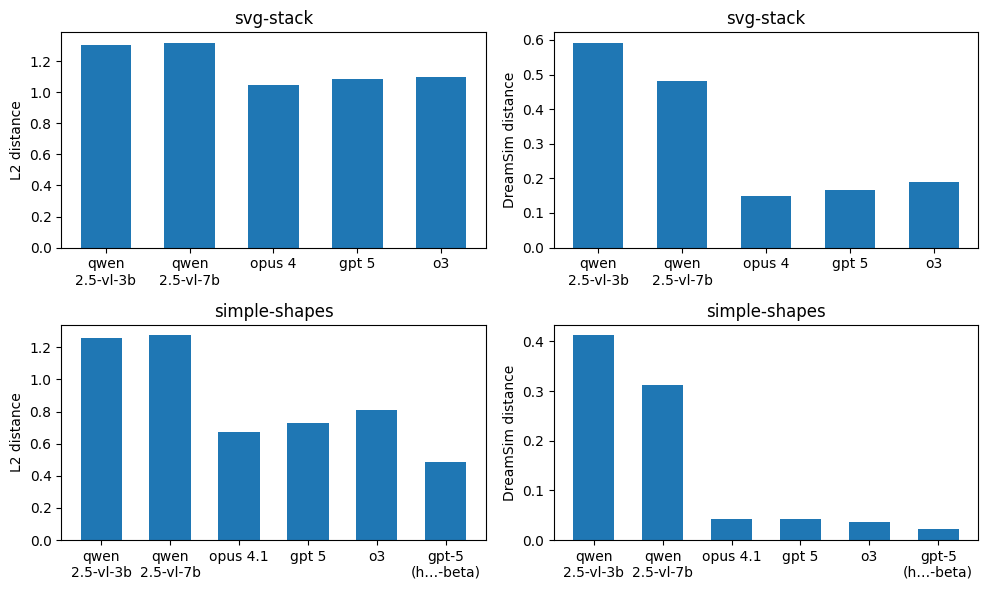

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

# 2x2 SVG charts: rows = datasets (svg-stack, simple-shapes), cols = metrics (l2 | dreamsim)
# from matplotlib_inline import backend_inline
# backend_inline.set_matplotlib_formats('svg')


# Clean and normalize model display names
# - drop leading 'claude-'
# - drop trailing dates like -20240101 or _20240101
# - normalize separators
# - ensure 'opus 4.1' formatting

# LUT for pretty model names: (regex, replacement or callable)
_PRETTY_MODEL_REGEX_LUT = [
    (re.compile(r"^claude-opus-4-1(?:[-_]?20\d{6})?$", re.I), "opus 4.1"),
    (re.compile(r"^claude-opus-4(?:[-_]?20\d{6})?$", re.I), "opus 4"),
    (re.compile(r"^gpt-4\.1(-(mini|nano))?$", re.I), lambda m: f"gpt-4.1{(' ' + m.group(2).title()) if m.group(2) else ''}"),
    (re.compile(r"^openrouter/horizon-beta$", re.I), "gpt-5\n(h…-beta)"),
    (re.compile(r"^Qwen/Qwen2\.5-VL-3B-Instruct$", re.I), "qwen\n2.5-vl-3b"),
    (re.compile(r"^Qwen/Qwen2\.5-VL-7B-Instruct$", re.I), "qwen\n2.5-vl-7b"),
]

def pretty_model_name(name: str) -> str:
    for pat, pretty in _PRETTY_MODEL_REGEX_LUT:
        m = pat.match(name)
        if m:
            return pretty(m) if callable(pretty) else pretty
    # Fallback: generic normalization
    name = re.sub(r'^claude-', '', name, flags=re.I)
    name = re.sub(r'[-_]?20\d{6}$', '', name)
    name = re.sub(r'[-_]', ' ', name)
    name = re.sub(r'\s+', ' ', name).strip()
    name = re.sub(r'(?i)\bopus\s*4\s*1\b', 'opus 4.1', name)
    return name

# Prepare data
row_datasets = [
    ("darknoon/svg-stack-filtered", "svg-stack"),
    ("darknoon/simple-shapes-svg", "simple-shapes"),
]
col_metrics = [
    ("l2", "L2 distance"),
    ("dreamsim", "DreamSim distance"),
]

# Determine width based on max number of models across all panes
def models_for(dataset: str, metric: str):
    dfm = (
        all_stats[(all_stats['dataset'] == dataset) & (all_stats['metric'] == metric)]
        [["model_name", "mean", "std"]]
        .sort_values("model_name")
        .copy()
    )
    dfm["model_name"] = dfm["model_name"].map(pretty_model_name)
    dfm["mean"] = pd.to_numeric(dfm["mean"], errors="coerce")
    dfm["std"] = pd.to_numeric(dfm["std"], errors="coerce").fillna(0.0)
    return dfm

max_models = 1
for d, _ in row_datasets:
    for m, _ in col_metrics:
        max_models = max(max_models, len(models_for(d, m)))

fig_width = max(10, max_models * 0.8)
fig, axes = plt.subplots(nrows=len(row_datasets), ncols=len(col_metrics), figsize=(fig_width, 6), squeeze=False)

for r, (dataset_full, dataset) in enumerate(row_datasets):
    for c, (metric, metric_label) in enumerate(col_metrics):
        ax = axes[r][c]
        dfm = models_for(dataset, metric)
        models = dfm["model_name"].tolist()
        vals = dfm["mean"].astype(float).values
        # errs = dfm["std"].astype(float).values
        x = np.arange(len(models))
        ax.bar(x, vals, width=0.6, capsize=3, ecolor="black", error_kw={"elinewidth": 1, "alpha": 0.6})
        ax.set_title(dataset)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=0, ha="center")
        ax.set_ylabel(metric_label)
        # ax.set_title()

plt.tight_layout()
plt.show()

